# **Customer Segmentation & Lifetime Value Analysis**

## **Business Problem**

Our marketing budget is being spent inefficiently. We use a "one-size-fits-all" approach, sending the same newsletters and promotions to our entire customer base. This means we're likely overspending on acquiring low-value customers and, more critically, not doing enough to retain our high-value ones. We need to identify our most valuable customer segments to personalize our marketing efforts, improve retention, and maximize return on investment.

## Work

In [139]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

### Load Dataset

In [140]:
df_fct = (
    pd.read_csv('data/fct_sales.csv')
    .assign(
        purchase_timestamp=lambda x: pd.to_datetime(x['purchase_timestamp'], format='%Y-%m-%d %H:%M:%S'),
        invoice_id=lambda x: x['invoice_id'].astype('str'),
        customer_id=lambda x: x['customer_id'].astype('str'),
        sales=lambda x: x['order_amt'] * x['product_price']
    )
)
df_fct.info()
display(df_fct.sample(10))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 779495 entries, 0 to 779494
Data columns (total 8 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   invoice_id          779495 non-null  object        
 1   product_id          779495 non-null  object        
 2   customer_id         779495 non-null  object        
 3   date_id             779495 non-null  object        
 4   order_amt           779495 non-null  int64         
 5   product_price       779495 non-null  float64       
 6   purchase_timestamp  779495 non-null  datetime64[ns]
 7   sales               779495 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 47.6+ MB


,invoice_id,product_id,customer_id,date_id,order_amt,product_price,purchase_timestamp,sales
87850,501156,48184,12748,2010-03-14,1,7.49,2010-03-14 16:09:00,7.49
217376,517471,21904,16170,2010-07-29,12,2.10,2010-07-29 11:58:00,25.20
240575,520359,85028L,16103,2010-08-25,12,1.95,2010-08-25 13:36:00,23.40
367461,534201,20871,13550,2010-11-21,12,1.25,2010-11-21 15:24:00,15.00
452333,545081,21218,16057,2011-02-28,6,3.75,2011-02-28 10:35:00,22.50
511454,552724,23049,13418,2011-05-11,2,8.25,2011-05-11 10:29:00,16.50
77201,499897,22055,14298,2010-03-03,16,1.45,2010-03-03 11:53:00,23.20
187428,513615,22410,15998,2010-06-27,1,1.25,2010-06-27 12:25:00,1.25
639191,568062,21402,14014,2011-09-23,24,0.12,2011-09-23 13:18:00,2.88
255468,522281,21313,16374,2010-09-13,4,0.85,2010-09-13 12:56:00,3.40


In [155]:
df_product = (
    pd.read_csv('data/dim_product.csv')
)
df_product.info()
display(df_product.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5315 entries, 0 to 5314
Data columns (total 2 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   product_id           5315 non-null   object
 1   product_description  5315 non-null   object
dtypes: object(2)
memory usage: 83.2+ KB


,product_id,product_description
0,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS
1,79323P,PINK CHERRY LIGHTS
2,79323W,WHITE CHERRY LIGHTS
3,22041,"RECORD FRAME 7"" SINGLE SIZE"
4,21232,STRAWBERRY CERAMIC TRINKET BOX


### RFM

In [141]:
from datetime import timedelta

df_rfm = (
    df_fct
    .assign(
        date_id=lambda x: pd.to_datetime(x['date_id'])
    )
    .groupby('customer_id', as_index=False)
    .agg(
        last_purchase_date=('date_id', 'max'),
        # frequency
        frequency=('invoice_id', 'nunique'),
        # monetary
        monetary=('sales', 'sum')
    )
    .assign(
        # recency
        recency=lambda x: (
            (x['last_purchase_date'].max() + timedelta(days=1)) - x['last_purchase_date']
        ).dt.days,
        r_rank=lambda x: pd.qcut(x['recency'], q=5, labels=[5, 4, 3, 2, 1], duplicates='drop'),
        f_rank=lambda x: pd.qcut(x['frequency'].rank(method='first'), q=5, labels=[1, 2, 3, 4, 5], duplicates='drop'),
        m_rank=lambda x: pd.qcut(x['monetary'], q=5, labels=[1, 2, 3, 4, 5], duplicates='drop'),
        rfm_score=lambda x: (
            x['r_rank'].astype('str') +
            x['f_rank'].astype('str') +
            x['m_rank'].astype('str')
        )
    )
)

display(df_rfm)

,customer_id,last_purchase_date,frequency,monetary,recency,r_rank,f_rank,m_rank,rfm_score
0,12346,2011-01-18,12,77556.46,326,2,5,5,255
1,12347,2011-12-07,8,4921.53,3,5,4,5,545
2,12348,2011-09-25,5,2019.40,76,3,4,4,344
3,12349,2011-11-21,4,4428.69,19,5,3,5,535
4,12350,2011-02-02,1,334.40,311,2,1,2,212
...,...,...,...,...,...,...,...,...,...
5876,18283,2011-12-06,22,2664.90,4,5,5,4,554
5877,18284,2010-10-04,1,461.68,432,1,2,2,122
5878,18285,2010-02-17,1,427.00,661,1,2,2,122
5879,18286,2010-08-20,2,1296.43,477,1,3,4,134


In [147]:
"""
Source: https://dspace.ut.ee/server/api/core/bitstreams/1ba7e6a6-2382-4541-918e-a93eecc5be80/content
"""


champions_scores = ['555', '554', '544', '545', '454', '455', '445']
loyal_customer_scores = ['543', '444', '435', '355', '354', '345', '344', '335']
potential_loyalist_scores = ['553', '551', '552', '541', '542', '533', '532', '531', '452', '451', '442', '441', '431', '453', '433', '432', '423', '353', '352', '351', '342', '341', '333', '323']
recent_buyers_scores = ['512', '511', '422', '421', '412', '411', '311']
promising_scores = ['525', '524', '523', '522', '521', '515', '514', '513', '425', '424', '413', '414', '415', '315', '314', '313']
need_attention_scores = ['535', '534', '443', '434', '343', '334', '325', '324']
about_to_sleep_scores = ['331', '321', '312', '221', '213', '231', '241', '251']
cannot_lose_them_scores = ['155', '154', '144', '214', '215', '115', '114', '113']
at_risk_scores = ['255', '254', '245', '244', '253', '252', '243', '242', '235', '234', '225', '224', '153', '152', '145', '143', '142', '135', '134', '133', '125', '124']
hibernating_scores = ['332', '322', '233', '232', '222', '223', '132', '123', '122', '212', '211']
lost_scores = ['111', '112', '121', '131', '141', '151']

conditions = [
    df_rfm['rfm_score'].isin(champions_scores),
    df_rfm['rfm_score'].isin(loyal_customer_scores),
    df_rfm['rfm_score'].isin(potential_loyalist_scores),
    df_rfm['rfm_score'].isin(recent_buyers_scores),
    df_rfm['rfm_score'].isin(promising_scores),
    df_rfm['rfm_score'].isin(need_attention_scores),
    df_rfm['rfm_score'].isin(about_to_sleep_scores),
    df_rfm['rfm_score'].isin(cannot_lose_them_scores),
    df_rfm['rfm_score'].isin(at_risk_scores),
    df_rfm['rfm_score'].isin(hibernating_scores),
    df_rfm['rfm_score'].isin(lost_scores),
]

choices = [
    'Champions',
    'Loyal Customer',
    'Potential loyalist',
    'Recent Buyers',
    'Promising',
    'Need Attention',
    'About to Sleep',
    'Cannot Lose Them',
    'At Risk',
    'Hibernating',
    'Lost'
]

# The paper mentions an "Others" category for unassigned scores
df_rfm['segment'] = np.select(conditions, choices, default='Others')

display(df_rfm)


,customer_id,last_purchase_date,frequency,monetary,recency,r_rank,f_rank,m_rank,rfm_score,segment
0,12346,2011-01-18,12,77556.46,326,2,5,5,255,At Risk
1,12347,2011-12-07,8,4921.53,3,5,4,5,545,Champions
2,12348,2011-09-25,5,2019.40,76,3,4,4,344,Loyal Customer
3,12349,2011-11-21,4,4428.69,19,5,3,5,535,Need Attention
4,12350,2011-02-02,1,334.40,311,2,1,2,212,Hibernating
...,...,...,...,...,...,...,...,...,...,...
5876,18283,2011-12-06,22,2664.90,4,5,5,4,554,Champions
5877,18284,2010-10-04,1,461.68,432,1,2,2,122,Hibernating
5878,18285,2010-02-17,1,427.00,661,1,2,2,122,Hibernating
5879,18286,2010-08-20,2,1296.43,477,1,3,4,134,At Risk


### Total Customers For Each Segment

In [143]:
(
    df_rfm
    .groupby('segment', as_index=False)
    .agg(
        total=('customer_id', 'nunique')
    )
    .assign(
        percentage=lambda x: round(x['total'] / df_rfm.shape[0], 3)
    )
    .sort_values('total', ascending=False)
    .reset_index(drop=True)
)

,segment,total,percentage
0,Champions,1148,0.195
1,Hibernating,1023,0.174
2,Lost,662,0.113
3,Loyal Customer,661,0.112
4,Potential loyalist,606,0.103
5,At Risk,519,0.088
6,Need Attention,341,0.058
7,Recent Buyers,340,0.058
8,About to Sleep,303,0.052
9,Promising,175,0.030


/var/folders/34/_j3kcpxd38lfbdvtp0clnhrw0000gn/T/ipykernel_14859/2696501121.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=segment_counts.index, y=segment_counts.values, palette=palette)


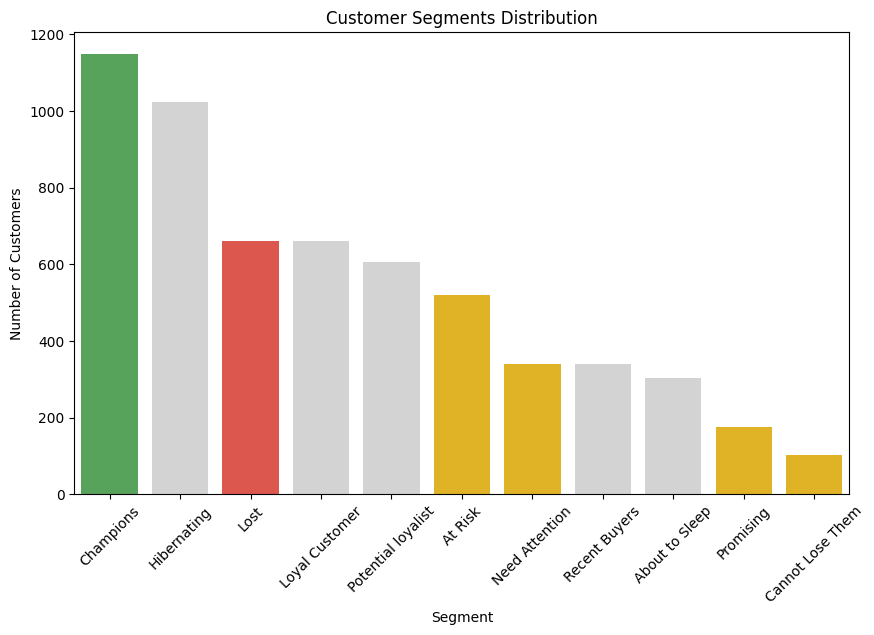

In [151]:
segment_counts = df_rfm['segment'].value_counts().sort_values(ascending=False)

highlight_map = {
    'Champions': '#4CAF50',
    'Promising': '#FFC107',
    'Need Attention': '#FFC107',
    'Cannot Lose Them': '#FFC107',
    'At Risk': '#FFC107',
    'Lost': '#F44336'
}

default_color = 'lightgray'

palette = [highlight_map.get(segment, default_color) for segment in segment_counts.index]

plt.figure(figsize=(10, 6))
sns.barplot(x=segment_counts.index, y=segment_counts.values, palette=palette)
plt.title('Customer Segments Distribution')
plt.xlabel('Segment')
plt.ylabel('Number of Customers')
plt.xticks(rotation=45)
plt.show()

### Total Revenue For Each Segment

,segment,revenue
3,Champions,1.156715e+07
6,Loyal Customer,2.127265e+06
1,At Risk,1.370844e+06
7,Need Attention,5.022163e+05
4,Hibernating,4.858475e+05
8,Potential loyalist,4.382332e+05
9,Promising,3.207488e+05
2,Cannot Lose Them,2.540465e+05
5,Lost,1.363633e+05
0,About to Sleep,8.925083e+04


/var/folders/34/_j3kcpxd38lfbdvtp0clnhrw0000gn/T/ipykernel_14859/3738119566.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=segment_revenue['segment'], y=segment_revenue['revenue'], palette=palette)


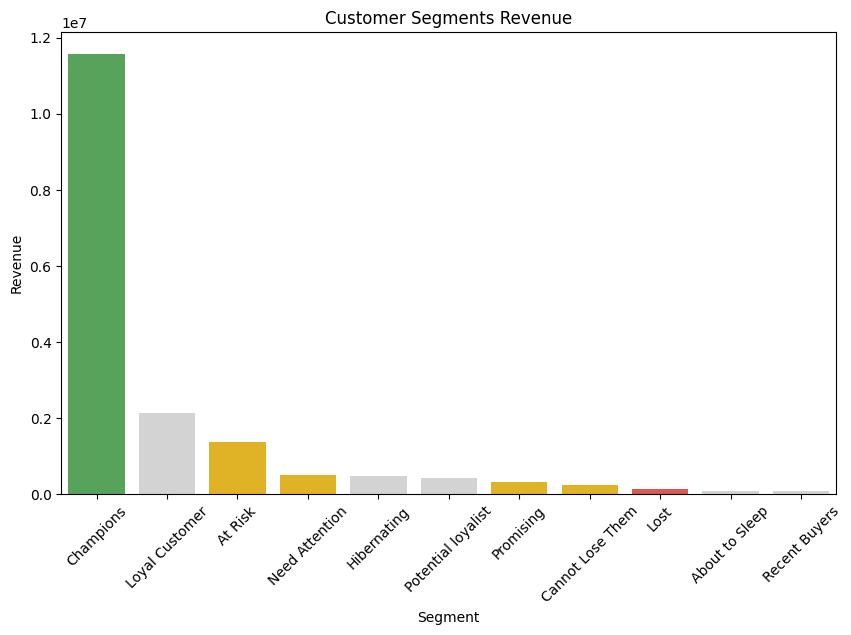

In [152]:
segment_revenue = (
    df_rfm
    .groupby('segment', as_index=False)
    .agg(
        revenue=('monetary', 'sum')
    )
    .sort_values('revenue', ascending=False)
)

display(segment_revenue)

highlight_map = {
    'Champions': '#4CAF50',
    'Promising': '#FFC107',
    'Need Attention': '#FFC107',
    'Cannot Lose Them': '#FFC107',
    'At Risk': '#FFC107',
    'Lost': '#F44336'
}

default_color = 'lightgray'

palette = [highlight_map.get(segment, default_color) for segment in segment_revenue['segment']]

plt.figure(figsize=(10, 6))
sns.barplot(x=segment_revenue['segment'], y=segment_revenue['revenue'], palette=palette)
plt.title('Customer Segments Revenue')
plt.xlabel('Segment')
plt.ylabel('Revenue')
plt.xticks(rotation=45)
plt.show()

### At Risk Segments

In [163]:
at_risk_segments = ['Need Attention', 'Promising', 'Cannot Lose Them', 'At Risk']

df_at_risk_segments = (
    df_rfm
    .loc[lambda x: x['segment'].isin(at_risk_segments)]
    [['customer_id']]
    .merge(
        df_fct[['customer_id', 'product_id', 'sales']],
        on='customer_id',
        how='left'
    )
    .merge(
        df_product,
        on='product_id',
        how='left'
    )
)

display(df_at_risk_segments.sample(10))

df_top_5_products_for_at_risk_segments = (
    df_at_risk_segments['product_description']
    .value_counts()
    .head(5)
    .reset_index()
)

display(df_top_5_products_for_at_risk_segments)

,customer_id,product_id,sales,product_description
58350,14625,23133,16.5,LARGE IVORY HEART WALL ORGANISER
126809,17829,22070,22.5,SMALL RETRO SPOT MUG IN BOX RED
42958,14013,22909,10.2,SET OF 20 VINTAGE CHRISTMAS NAPKINS
28373,13405,22426,15.0,ENAMEL WASH BOWL CREAM
45973,14121,23127,19.8,FELTCRAFT GIRL NICOLE KIT
24538,13239,22384,16.5,LUNCHBAG PINK RETROSPOT
47433,14154,23230,10.5,WRAP ALPHABET DESIGN
87241,16004,85123A,35.4,CREAM HANGING HEART T-LIGHT HOLDER
50690,14320,21737,39.9,SET 3 WICKER LOG BASKETS
107446,16806,22832,21.5,BROCANTE SHELF WITH HOOKS


,product_description,count
0,CREAM HANGING HEART T-LIGHT HOLDER,833
1,WHITE HANGING HEART T-LIGHT HOLDER,833
2,REGENCY CAKESTAND 3 TIER,454
3,JUMBO BAG RED RETROSPOT,356
4,RED RETROSPOT JUMBO BAG,356


### Loss Segment

In [165]:
df_loss_segments = (
    df_rfm
    .loc[lambda x: x['segment'] == 'Lost']
    [['customer_id']]
    .merge(
        df_fct[['customer_id', 'product_id', 'sales']],
        on='customer_id',
        how='left'
    )
    .merge(
        df_product,
        on='product_id',
        how='left'
    )
)

display(df_loss_segments)

df_top_5_products_for_loss_segments = (
    df_at_risk_segments['product_description']
    .value_counts()
    .head(5)
    .reset_index()
)

display(df_top_5_products_for_loss_segments)

,customer_id,product_id,sales,product_description
0,12366,21135,162.24,VICTORIAN METAL POSTCARD SPRING
1,12366,21136,162.24,PAINTED METAL PEARS ASSORTED
2,12366,84879,175.76,ASSORTED COLOUR BIRD ORNAMENT
3,12387,22540,10.08,MINI JIGSAW CIRCUS PARADE
4,12387,22539,10.08,MINI JIGSAW DOLLY GIRL
...,...,...,...,...
13513,18279,85230A,20.88,OPIUM SCENTED VOTIVE CANDLE
13514,18279,85231G,10.20,ORANGE SCENTED SET/9 T-LIGHTS
13515,18279,85231B,20.40,CINAMMON SET OF 9 T-LIGHTS
13516,18279,20733,8.50,GOLD MINI TAPE MEASURE


,product_description,count
0,CREAM HANGING HEART T-LIGHT HOLDER,833
1,WHITE HANGING HEART T-LIGHT HOLDER,833
2,REGENCY CAKESTAND 3 TIER,454
3,JUMBO BAG RED RETROSPOT,356
4,RED RETROSPOT JUMBO BAG,356
